# Analyzing tweets with #resist

In [1]:
import pandas as pd
import pickle
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pyLDAvis
import pyLDAvis.sklearn
from textblob import TextBlob
import gensim
from gensim import corpora, models, similarities, matutils
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import logging
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/Users/lorenadelaparralanda/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)
/Users/lorenadelaparralanda/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-03-03 15:07:29.488131. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
import warnings
warnings.filterwarnings('ignore')

# I. Load tweets

In [3]:
# Activate Mongo
from pymongo import MongoClient
client = MongoClient('ec2-54-172-141-211.compute-1.amazonaws.com', 27017)

In [4]:
# Check count of tweets in collection
client.fletcher.resist.count()

216382

In [5]:
# Bring in tweets from collection in the shape of a dataframe
resist = pd.DataFrame(list(client.fletcher.resist.find()))

In [6]:
# Pickle dataframe
with open('raw_resist.pkl', 'wb') as picklefile:
    pickle.dump(resist, picklefile)

In [7]:
# Bring in pickle
with open("raw_resist.pkl", 'rb') as picklefile:
    resist = pickle.load(picklefile)

In [8]:
resist.shape

(216382, 24)

In [9]:
# Drop duplicates - no duplicates found
resist = resist.drop_duplicates(['id','tweet'])
resist.shape

(216382, 24)

In [10]:
resist.head()

,_id,author,contributors,coordinates,datetime,entities,favorited,favorites_count,id,is_quote,...,retweet,retweet_count,retweeted,retweeted_count,retweets,source,source_url,truncated,tweet,user
0,58b3a8107f84670625c5fdcd,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:16:01,"{u'symbols': [], u'user_mentions': [{u'id': 29...",False,0,836067336813744129,False,...,<bound method Status.retweet of Status(contrib...,357,False,False,<bound method Status.retweets of Status(contri...,Twitter for iPhone,http://twitter.com/download/iphone,False,RT @Momblastic: Crowdfunded ad in Sunday's @de...,"User(follow_request_sent=False, has_extended_p..."
1,58b3a8107f84670625c5fdce,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:16:00,"{u'symbols': [], u'user_mentions': [], u'hasht...",False,0,836067335840616449,False,...,<bound method Status.retweet of Status(contrib...,1,False,False,<bound method Status.retweets of Status(contri...,TweetDeck,https://about.twitter.com/products/tweetdeck,True,I will follow all who REWEET this #RESIST PIC ...,"User(follow_request_sent=False, has_extended_p..."
2,58b3a8117f84670625c5fdcf,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:16:00,"{u'symbols': [], u'user_mentions': [{u'id': 16...",False,0,836067332296429568,False,...,<bound method Status.retweet of Status(contrib...,27,False,False,<bound method Status.retweets of Status(contri...,TweetDeck,https://about.twitter.com/products/tweetdeck,False,RT @ActionTime: Please RETWEET to SABOTAGE Tru...,"User(follow_request_sent=False, has_extended_p..."
3,58b3a8117f84670625c5fdd0,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:15:58,"{u'symbols': [], u'user_mentions': [{u'id': 29...",False,0,836067325245784069,False,...,<bound method Status.retweet of Status(contrib...,357,False,False,<bound method Status.retweets of Status(contri...,Twitter for iPhone,http://twitter.com/download/iphone,False,RT @Momblastic: Crowdfunded ad in Sunday's @de...,"User(follow_request_sent=False, has_extended_p..."
4,58b3a8117f84670625c5fdd1,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:15:58,"{u'symbols': [], u'user_mentions': [{u'id': 29...",False,0,836067324415336448,False,...,<bound method Status.retweet of Status(contrib...,357,False,False,<bound method Status.retweets of Status(contri...,Twitter for iPad,http://twitter.com/#!/download/ipad,False,RT @Momblastic: Crowdfunded ad in Sunday's @de...,"User(follow_request_sent=False, has_extended_p..."


In [11]:
resist.columns

Index([u'_id', u'author', u'contributors', u'coordinates', u'datetime',
       u'entities', u'favorited', u'favorites_count', u'id', u'is_quote',
       u'language', u'location', u'replied_to_id', u'replied_to_name',
       u'retweet', u'retweet_count', u'retweeted', u'retweeted_count',
       u'retweets', u'source', u'source_url', u'truncated', u'tweet', u'user'],
      dtype='object')

In [12]:
# Functions to clean tweets 

def decode_tweet(x): 
    x = x.encode('ascii', 'ignore')
    return x

def cleantweet(x):
    splitt = x.split(" ")
    cleantweet = [ x for x in splitt if "http" not in x ]
    cleantweet2 = [x for x in cleantweet if "RT" not in x]
    return cleantweet2

def jointweet(x):
    x = " ".join(x)
    return x

In [13]:
resist['decode_tweet'] = resist.tweet.apply(decode_tweet)
resist['clean_tweet'] = resist.decode_tweet.apply(cleantweet)
resist['clean_joint_tweet'] = resist.clean_tweet.apply(jointweet)

In [14]:
resist.iloc[0]['clean_joint_tweet']

"@Momblastic: Crowdfunded ad in Sunday's @denverpost #doyourjob #resist cc:@IndivisibleTeam @samswey @indivisiblefrr @indivisibleden @Ind"

In [15]:
# Make a list of all tweets
all_tweets = []
for tweet in resist.clean_tweet:
    joint = " ".join(tweet)
    all_tweets.append(joint)
    
len(all_tweets)

216382

In [16]:
all_tweets[0]

"@Momblastic: Crowdfunded ad in Sunday's @denverpost #doyourjob #resist cc:@IndivisibleTeam @samswey @indivisiblefrr @indivisibleden @Ind"

In [17]:
# Pickled all tweets 
with open('resist_tweets.pkl', 'wb') as picklefile:
    pickle.dump(all_tweets, picklefile)

# II. Explore

In [18]:
# Majority of tweets do not have coordinates
resist.coordinates.value_counts(ascending=False).head()

None                                                                216253
{u'type': u'Point', u'coordinates': [-97.740582, 30.273402]}            10
{u'type': u'Point', u'coordinates': [-73.95013, 40.80991]}               4
{u'type': u'Point', u'coordinates': [-72.50521429, 42.16062457]}         3
{u'type': u'Point', u'coordinates': [-77.06073942, 38.940161]}           3
Name: coordinates, dtype: int64

In [19]:
# Most frequent tweets
resist.decode_tweet.value_counts(ascending=False).head()

RT @funder: #BREAKING:UK officials now think Russia may have interfered with the Brexit vote\n\n#trumprussia #russiagate #resist https://t.co      3638
RT @KeithOlbermann: EXACTLY. #Resist https://t.co/9WmzeKAeC9                                                                                       2203
RT @funder: #BREAKING:Ivanka was in Russia w/wife of oligarch-he was major investor in Rosneft-oil co from dossier\n\n#trumprussia #resist #t      2185
RT @funder: #BREAKING:Intelligence official says most of the #TrumpDossier is "bearing out"-aka true.\n\n#trumprussia #russiagate #resist #th      1810
RT @AltStateDpt: RT- #Resist strategically.\n\nOur 1st list of politically vulnerable GOP Reps by 2016 election data.\n\nTime to pick our battl    1698
Name: decode_tweet, dtype: int64

In [20]:
# Most frequent tweeter
resist.id.value_counts(ascending=False).head()

836013399486128130    1
835321510227136512    1
835665389396742144    1
835336103448227840    1
835699497657233408    1
Name: id, dtype: int64

# III. Remove retweets

In [21]:
# Drop all retweets
nodup_resist = resist.drop_duplicates(['tweet'])
nodup_resist.shape

(68258, 27)

In [22]:
# Make a list of all non-duplicated tweets
no_dup_all_tweets = []
for tweet in nodup_resist.clean_tweet:
    joint = " ".join(tweet)
    no_dup_all_tweets.append(joint)
    
len(no_dup_all_tweets)

68258

In [23]:
no_dup_all_tweets[0]

"@Momblastic: Crowdfunded ad in Sunday's @denverpost #doyourjob #resist cc:@IndivisibleTeam @samswey @indivisiblefrr @indivisibleden @Ind"

In [24]:
# Look at most frequent languages
nodup_resist.language.value_counts(ascending=False).head()

en     58821
und     8539
es       163
fr       108
in        71
Name: language, dtype: int64

# IV. Topic Modeling

## CountVectorizer

In [25]:
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
vectorizer.fit(no_dup_all_tweets)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
counts_transpose = vectorizer.transform(no_dup_all_tweets).transpose()
counts_transpose.shape

(312791, 68258)

In [27]:
counts = vectorizer.transform(no_dup_all_tweets)
counts.shape

(68258, 312791)

In [28]:
corpus = matutils.Sparse2Corpus(counts_transpose)

In [29]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
len(id2word)

312791

In [30]:
words = id2word.values()
len(words)

312791

# CountVectorizer + LDA

In [215]:
CVlda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=5)

In [216]:
CVlda.print_topics()

[(0,
  u'0.037*"resist" + 0.003*"amp" + 0.003*"dictatorship" + 0.002*"trump" + 0.002*"just" + 0.002*"need" + 0.002*"vote" + 0.002*"don" + 0.002*"way" + 0.002*"aclu"'),
 (1,
  u'0.044*"resist" + 0.008*"theresistance" + 0.008*"indivisible" + 0.007*"persist" + 0.007*"trump" + 0.005*"resist persist" + 0.004*"realdonaldtrump" + 0.004*"impeach" + 0.004*"news" + 0.004*"resistance"'),
 (2,
  u'0.052*"resist" + 0.013*"realdonaldtrump" + 0.006*"potus" + 0.005*"white" + 0.004*"america" + 0.004*"like" + 0.004*"trump" + 0.004*"house" + 0.004*"people" + 0.004*"amp"'),
 (3,
  u'0.047*"resist" + 0.018*"trump" + 0.015*"trumprussia" + 0.014*"theresistance" + 0.013*"freedomofthepress" + 0.010*"russiagate" + 0.008*"resistance" + 0.007*"russia" + 0.007*"impeachtrump" + 0.006*"resist theresistance"'),
 (4,
  u'0.040*"resist" + 0.012*"amp" + 0.006*"fighting" + 0.006*"fighting resist" + 0.006*"followed" + 0.006*"grateful" + 0.006*"followfriday" + 0.006*"humbled" + 0.006*"resist followfriday" + 0.006*"amp grat

## pyLDAvis w/ Countvectorizer

In [31]:
lda_tf = LatentDirichletAllocation(n_topics=5, random_state=0)
lda_tf.fit(counts)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=5, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tf, counts, vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      23.596248        1       1  0.237789  0.017899
0      20.914805        1       2 -0.081650 -0.220218
1      18.987522        1       3 -0.140397  0.164903
2      18.286059        1       4 -0.025531 -0.015535
3      18.215366        1       5  0.009788  0.052950, topic_info=       Category         Freq                   Term         Total  loglift  \
term                                                                         
270335  Default  5591.000000          theresistance   5591.000000  30.0000   
283990  Default  4230.000000            trumprussia   4230.000000  29.0000   
225965  Default  3278.000000             resistance   3278.000000  28.0000   
225137  Default  2133.000000   resist theresistance   2133.000000  27.0000   
233889  Default  2083.000000             russiagate   2083.000000  26.0000   
197083  Default  1725.000000                  potus   1725.000000  25.0000   
95013   Default  1869.000000      freedomofthepress   1869.000000  24.0000   
270791  Default  1672.000000   theresistance resist   1672.000000  23.0000   
122785  Default  2576.000000           impeachtrump   2576.000000  22.0000   
177701  Default  1336.000000         notmypresident   1336.000000  21.0000   
43624   Default  1433.000000                    cnn   1433.000000  20.0000   
147693  Default  1618.000000                   like   1618.000000  19.0000   
179323  Default  1239.000000                nytimes   1239.000000  18.0000   
8529    Default  1137.000000                america   1137.000000  17.0000   
190775  Default  1613.000000                persist   1613.000000  16.0000   
233381  Default  1631.000000                 russia   1631.000000  15.0000   
155340  Default  1055.000000                   maga   1055.000000  14.0000   
71083   Default  1537.000000                    don   1537.000000  13.0000   
124769  Default  1806.000000            indivisible   1806.000000  12.0000   
200313  Default  1455.000000                  press   1455.000000  11.0000   
122156  Default  1063.000000                impeach   1063.000000  10.0000   
117458  Default  1048.000000                  house   1048.000000   9.0000   
224288  Default  1602.000000      resist resistance   1602.000000   8.0000   
223798  Default  1232.000000         resist persist   1232.000000   7.0000   
174099  Default  1382.000000                   news   1382.000000   6.0000   
61567   Default   857.000000              democracy    857.000000   5.0000   
222549  Default   756.000000    resist impeachtrump    756.000000   4.0000   
297930  Default   753.000000                   want    753.000000   3.0000   
199483  Default   872.000000              president    872.000000   2.0000   
51814   Default   789.000000                country    789.000000   1.0000   
...         ...          ...                    ...           ...      ...   
87060    Topic5   374.329670                    fbi    374.979595   1.7012   
266587   Topic5   378.246539                   tell    378.905818   1.7012   
276522   Topic5   359.974563               tomperez    360.603619   1.7012   
86122    Topic5   360.964971                fascism    361.612948   1.7011   
132612   Topic5   322.329290                    job    322.968640   1.7009   
177877   Topic5   309.691364  notmypresident resist    310.320467   1.7009   
13424    Topic5   300.758983                   anti    301.402603   1.7008   
137164   Topic5   265.457115           keithellison    266.083318   1.7005   
91783    Topic5   258.338829                 follow    258.978475   1.7004   
258724   Topic5   255.860627                  story    256.507446   1.7004   
298731   Topic5   254.427584                    war    255.071500   1.7004   
125346   Topic5   240.672440        indivisibleteam    241.312489   1.7002   
99858    Topic5   242.448417                getting    243.099896   1

# CountVectorizer + NMF

In [219]:
from sklearn.decomposition import NMF
modelNMF = NMF(n_components=5, init='random', random_state=0)

In [220]:
CV_NMF_topics = modelNMF.fit_transform(counts)
CV_NMF_cluster = [list(r).index(max(r)) for r in CV_NMF_topics]

In [221]:
modelNMF.components_

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.42516393e-05,   0.00000000e+00,   0.00000000e+00],
       [  9.63065604e-04,   9.63065604e-04,   1.80020406e-04, ...,
          9.80344256e-04,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   7.01053419e-03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   1.28708619e-02,   1.28708619e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [222]:
topic_words = []
for r in modelNMF.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])

In [223]:
topic_words

[[u'realdonaldtrump',
  u'nytimes',
  u'potus',
  u'cnn',
  u'impeachtrump',
  u'realdonaldtrump nytimes',
  u'nytimes cnn'],
 [u'resist',
  u'resistance',
  u'persist',
  u'resist resist',
  u'people',
  u'resist persist',
  u'just'],
 [u'theresistance',
  u'trumprussia',
  u'resist theresistance',
  u'russiagate',
  u'theresistance resist',
  u'resistance',
  u'trumprussia russiagate'],
 [u'trump',
  u'russia',
  u'trump resist',
  u'resist trump',
  u'trump russia',
  u'donald',
  u'donald trump'],
 [u'amp',
  u'fighting',
  u'fighting resist',
  u'grateful',
  u'followed',
  u'followfriday',
  u'humbled']]

In [224]:
U, Sigma, VT = randomized_svd(counts, n_components=15,
                                      n_iter=5,
                                      random_state=None)

In [225]:
Sigma

array([ 267.84662913,  101.90422251,   97.48334639,   87.66096495,
         85.6046339 ,   81.99407422,   73.37503916,   66.85748005,
         60.82209045,   59.58200029,   58.20695506,   57.77305298,
         52.62928809,   52.16425769,   51.71216852])

___________

# TFIDF

In [33]:
vectorizer2 = TfidfVectorizer(stop_words="english", ngram_range=(1,2))

In [34]:
TFIDF_counts = vectorizer2.fit_transform(no_dup_all_tweets)
TFIDF_counts.shape

(68258, 334658)

In [35]:
TFIDF_counts_transpose = vectorizer2.fit_transform(no_dup_all_tweets).transpose()
TFIDF_counts_transpose.shape

(334658, 68258)

In [36]:
corpus2 = matutils.Sparse2Corpus(TFIDF_counts_transpose)

In [37]:
id2word2 = dict((v, k) for k, v in vectorizer2.vocabulary_.items())
len(id2word2)

334658

In [38]:
words2 = id2word2.values()
len(words2)

334658

# TFIDF + LDA

In [234]:
ldaTFIDF = models.LdaModel(corpus=corpus2, num_topics=5, id2word=id2word2, passes=5)

In [235]:
ldaTFIDF.print_topics()

[(0,
  u'0.003*"resist" + 0.001*"russiagate" + 0.001*"impeach45 russiagate" + 0.001*"freedomofthepress dossier" + 0.001*"aca presidentbannon" + 0.001*"dossier aca" + 0.001*"dossier" + 0.001*"presidentbannon" + 0.001*"resist freedomofthepress" + 0.001*"freedomofthepress"'),
 (1,
  u'0.006*"resist" + 0.004*"theresistance" + 0.004*"trumprussia" + 0.003*"freedomofthepress" + 0.003*"trump" + 0.003*"impeachtrump" + 0.003*"resistance" + 0.002*"realdonaldtrump" + 0.002*"resist theresistance" + 0.002*"theresistance resist"'),
 (2,
  u'0.003*"resist" + 0.002*"amp" + 0.002*"fighting" + 0.002*"fighting resist" + 0.002*"followed" + 0.002*"followfriday" + 0.002*"humbled" + 0.002*"resist followfriday" + 0.002*"followed fighting" + 0.002*"humbled amp"'),
 (3,
  u'0.002*"resist" + 0.001*"people" + 0.001*"blocking" + 0.001*"realdonaldtrump" + 0.001*"democracy resist" + 0.001*"like" + 0.001*"day" + 0.001*"p2" + 0.001*"freepress resist" + 0.001*"democracy"'),
 (4,
  u'0.017*"resist" + 0.001*"persist" + 0.

## pyLDAvis with TFIDF

In [39]:
lda_tfidf = LatentDirichletAllocation(n_topics=3, random_state=0)
lda_tfidf.fit(TFIDF_counts)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=3, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [40]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tfidf, TFIDF_counts, vectorizer2)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      46.878160        1       1 -0.071934  0.010982
2      31.716574        1       2  0.025132 -0.060178
1      21.405267        1       3  0.046801  0.049195, topic_info=       Category        Freq                       Term        Total  loglift  \
term                                                                           
304779  Default  237.000000                trumprussia   237.000000  30.0000   
252354  Default  134.000000                 russiagate   134.000000  29.0000   
136379  Default  142.000000                indivisible   142.000000  28.0000   
290616  Default  335.000000              theresistance   335.000000  27.0000   
105295  Default  156.000000          freedomofthepress   156.000000  26.0000   
251837  Default   92.000000                     russia    92.000000  25.0000   
305128  Default   72.000000         trumprussia resist    72.000000  24.0000   
243349  Default   64.000000         resist trumprussia    64.000000  23.0000   
252552  Default   63.000000          russiagate resist    63.000000  22.0000   
243943  Default  224.000000                 resistance   224.000000  21.0000   
305147  Default   54.000000     trumprussia russiagate    54.000000  20.0000   
291093  Default  141.000000       theresistance resist   141.000000  19.0000   
99183   Default   47.000000            fighting resist    47.000000  18.0000   
228822  Default  313.000000            realdonaldtrump   313.000000  17.0000   
116307  Default   45.000000                   grateful    45.000000  16.0000   
207635  Default  144.000000                    persist   144.000000  15.0000   
193836  Default  115.000000             notmypresident   115.000000  14.0000   
102067  Default   45.000000                   followed    45.000000  13.0000   
102156  Default   45.000000               followfriday    45.000000  12.0000   
130036  Default   44.000000                    humbled    44.000000  11.0000   
239846  Default   44.000000        resist followfriday    44.000000  10.0000   
130037  Default   44.000000                humbled amp    44.000000   9.0000   
102072  Default   44.000000          followed fighting    44.000000   8.0000   
16784   Default   44.000000               amp grateful    44.000000   7.0000   
116316  Default   44.000000          grateful followed    44.000000   6.0000   
206082  Default  140.000000                     people   140.000000   5.0000   
134301  Default  187.000000               impeachtrump   187.000000   4.0000   
195569  Default   93.000000                    nytimes    93.000000   3.0000   
107470  Default   42.000000                     funder    42.000000   2.0000   
99088   Default   60.000000                   fighting    60.000000   1.0000   
...         ...         ...                        ...          ...      ...   
107470   Topic3   42.571735                     funder    42.926776   1.5332   
242363   Topic3   24.179256          resist russiagate    24.543376   1.5266   
81765    Topic3   18.088091                    dossier    18.397729   1.5246   
305229   Topic3   19.490334  trumprussia theresistance    19.827488   1.5244   
255646   Topic3   26.574844                    saveaca    27.034625   1.5244   
155475   Topic3   19.961171                     latest    20.314242   1.5240   
252184   Topic3   20.652058              russia resist    21.020823   1.5238   
271843   Topic3   18.186716          specialprosecutor    18.511928   1.5238   
252629   Topic3   17.444204     russiagate trumprussia    17.757993   1.5237   
140372   Topic3   22.955785              investigation    23.374680   1.5234   
245118   Topic3   16.529721           resistpeacefully    16.835384   1.5232   
245120   Topic3   16.489232    resistpeacefully resist    16.794885   1.5232   
192401   Topic3   16.226697                  nogorsuch    16.532305   1.5229   
302913 

# TFIDF  + NMF - 2 topics

In [250]:
from sklearn.decomposition import NMF
modelNMF2 = NMF(n_components=2, init='random', random_state=0)

In [251]:
TFIDF_NMF_topics = modelNMF2.fit_transform(TFIDF_counts)
TFIDF_NMF_cluster = [list(r).index(max(r)) for r in TFIDF_NMF_topics]

In [252]:
modelNMF2.components_

array([[  6.34100253e-04,   1.06771842e-06,   1.09280192e-07, ...,
          1.05999176e-04,   9.41832475e-05,   9.41832475e-05],
       [  2.73938208e-04,   3.93500725e-06,   1.05087725e-05, ...,
          1.82200888e-04,   1.26680601e-04,   1.26680601e-04]])

In [253]:
topic_words2 = []
for r in modelNMF2.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:10]
    topic_words2.append([words2[e[1]] for e in a])

In [254]:
topic_words2

[[u'resist',
  u'realdonaldtrump',
  u'persist',
  u'trump',
  u'resist persist',
  u'resistance',
  u'amp',
  u'resist resistance',
  u'impeachtrump',
  u'resist resist'],
 [u'theresistance',
  u'trumprussia',
  u'resist theresistance',
  u'russiagate',
  u'theresistance resist',
  u'trumprussia russiagate',
  u'russiagate resist',
  u'resistance',
  u'trumprussia resist',
  u'resist trumprussia']]

In [255]:
U, Sigma, VT = randomized_svd(TFIDF_counts, n_components=15,
                                      n_iter=5,
                                      random_state=None)

In [256]:
Sigma

array([ 34.23629369,  17.072886  ,  13.39431429,  12.4934884 ,
        12.42041944,  11.94648634,  11.28472604,  11.11542475,
        10.92837437,  10.37420429,  10.00854223,   9.77596879,
         9.67538362,   9.4886865 ,   9.22077525])

# TFIDF  + NMF - 3 topics

In [260]:
modelNMF2 = NMF(n_components=3, init='random', random_state=0)

In [261]:
TFIDF_NMF_topics = modelNMF2.fit_transform(TFIDF_counts)
TFIDF_NMF_cluster = [list(r).index(max(r)) for r in TFIDF_NMF_topics]

In [262]:
modelNMF2.components_

array([[  5.61483955e-04,   9.44306921e-07,   0.00000000e+00, ...,
          9.47065539e-05,   8.54393500e-05,   8.54393500e-05],
       [  2.49669810e-04,   3.80931831e-06,   1.00306101e-05, ...,
          1.75927436e-04,   1.24281233e-04,   1.24281233e-04],
       [  4.47302701e-04,   9.55914344e-07,   5.15796876e-06, ...,
          5.40855694e-05,   1.86134986e-06,   1.86134986e-06]])

In [263]:
topic_words2 = []
for r in modelNMF2.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:10]
    topic_words2.append([words2[e[1]] for e in a])

In [264]:
topic_words2

[[u'resist',
  u'realdonaldtrump',
  u'persist',
  u'trump',
  u'resist persist',
  u'resistance',
  u'resist resistance',
  u'impeachtrump',
  u'resist resist',
  u'freedomofthepress'],
 [u'theresistance',
  u'trumprussia',
  u'resist theresistance',
  u'russiagate',
  u'theresistance resist',
  u'trumprussia russiagate',
  u'russiagate resist',
  u'resistance',
  u'trumprussia resist',
  u'resist trumprussia'],
 [u'fighting resist',
  u'fighting',
  u'humbled amp',
  u'grateful followed',
  u'followed fighting',
  u'amp grateful',
  u'resist followfriday',
  u'humbled',
  u'followfriday',
  u'followed']]

---

# V. Sentiment

In [41]:
# Functions to gather sentiment from tweets
def sentiment(x):
    blob = TextBlob(x)
    sentiment = blob.sentiment
    return sentiment

def sentiment_polarity(x):
    blob = TextBlob(x)
    sentiment = blob.sentiment
    return sentiment[0]

def sentiment_subjectivity(x):
    blob = TextBlob(x)
    sentiment = blob.sentiment
    return sentiment[1]

In [42]:
nodup_resist['sentiment'] = nodup_resist.clean_joint_tweet.apply(sentiment)
nodup_resist['polarity'] = nodup_resist.clean_joint_tweet.apply(sentiment_polarity)
nodup_resist['subjectivity'] = nodup_resist.clean_joint_tweet.apply(sentiment_subjectivity)

In [43]:
nodup_resist.head()

,_id,author,contributors,coordinates,datetime,entities,favorited,favorites_count,id,is_quote,...,source_url,truncated,tweet,user,decode_tweet,clean_tweet,clean_joint_tweet,sentiment,polarity,subjectivity
0,58b3a8107f84670625c5fdcd,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:16:01,"{u'symbols': [], u'user_mentions': [{u'id': 29...",False,0,836067336813744129,False,...,http://twitter.com/download/iphone,False,RT @Momblastic: Crowdfunded ad in Sunday's @de...,"User(follow_request_sent=False, has_extended_p...",RT @Momblastic: Crowdfunded ad in Sunday's @de...,"[@Momblastic:, Crowdfunded, ad, in, Sunday's, ...",@Momblastic: Crowdfunded ad in Sunday's @denve...,"(0.0, 0.0)",0.0,0.000000
1,58b3a8107f84670625c5fdce,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:16:00,"{u'symbols': [], u'user_mentions': [], u'hasht...",False,0,836067335840616449,False,...,https://about.twitter.com/products/tweetdeck,True,I will follow all who REWEET this #RESIST PIC ...,"User(follow_request_sent=False, has_extended_p...",I will follow all who REWEET this #RESIST PIC ...,"[I, will, follow, all, who, REWEET, this, #RES...",I will follow all who REWEET this #RESIST PIC ...,"(0.0, 0.0)",0.0,0.000000
2,58b3a8117f84670625c5fdcf,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:16:00,"{u'symbols': [], u'user_mentions': [{u'id': 16...",False,0,836067332296429568,False,...,https://about.twitter.com/products/tweetdeck,False,RT @ActionTime: Please RETWEET to SABOTAGE Tru...,"User(follow_request_sent=False, has_extended_p...",RT @ActionTime: Please RETWEET to SABOTAGE Tru...,"[@ActionTime:, Please, RETWEET, to, SABOTAGE, ...",@ActionTime: Please RETWEET to SABOTAGE Trump'...,"(-0.6, 1.0)",-0.6,1.000000
5,58b3a8117f84670625c5fdd2,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:15:57,"{u'symbols': [], u'user_mentions': [{u'id': 82...",False,0,836067322431328256,False,...,http://twitter.com/download/android,False,RT @TrumpsACartoon: #Cartoon by John Deering\n...,"User(follow_request_sent=False, has_extended_p...",RT @TrumpsACartoon: #Cartoon by John Deering\n...,"[@TrumpsACartoon:, #Cartoon, by, John, Deering...",@TrumpsACartoon: #Cartoon by John Deering\n#Tr...,"(0.0, 0.0)",0.0,0.000000
6,58b3a8117f84670625c5fdd3,"User(follow_request_sent=False, has_extended_p...",None,None,2017-02-27 04:15:57,"{u'symbols': [], u'user_mentions': [{u'id': 25...",False,0,836067321986891778,False,...,http://twitter.com/download/iphone,False,RT @2011teacher: #Trump Can't Sell Fear Unless...,"User(follow_request_sent=False, has_extended_p...",RT @2011teacher: #Trump Can't Sell Fear Unless...,"[@2011teacher:, #Trump, Can't, Sell, Fear, Unl...",@2011teacher: #Trump Can't Sell Fear Unless th...,"(0.0, 0.0666666666667)",0.0,0.066667


In [44]:
# Half of sentiments come out neutral
nodup_resist.subjectivity.value_counts(ascending=False).head()

0.00    33902
1.00     4108
0.50     3122
0.90     1389
0.75     1275
Name: subjectivity, dtype: int64

---

# VI. Word2vec

In [46]:
# Prepare words in tweets for word2vec
all_words_word2vec = []

remove = string.punctuation
remove = remove.replace("@", "") # don't remove @
remove = remove.replace("#", "") # don't remove #
pattern = r"[{}]".format(remove) # create the pattern

for tweet in nodup_resist.clean_joint_tweet:
    tweet = re.sub(pattern, "", tweet)
    words = tweet.split()
    all_words_word2vec.append(words)
    
len(all_words_word2vec)

68258

In [48]:
all_words_word2vec[0]

['@Momblastic',
 'Crowdfunded',
 'ad',
 'in',
 'Sundays',
 '@denverpost',
 '#doyourjob',
 '#resist',
 'cc@IndivisibleTeam',
 '@samswey',
 '@indivisiblefrr',
 '@indivisibleden',
 '@Ind']

In [277]:
word2vec = gensim.models.Word2Vec(all_words_word2vec,min_count=1,workers=2,sg=2,window=5)

In [279]:
word2vec['#resist']

array([ 0.21902187, -0.22495897,  0.67362213, -0.53180534, -0.05769561,
        0.28472391, -0.54423451,  0.57049084, -0.24507512, -0.01992458,
       -0.11665192, -0.16452432, -0.71983838,  0.48303518,  0.30634141,
        0.51251727, -0.15765469,  0.03479763,  0.15003328, -0.66348559,
       -0.58808285, -0.13108765,  0.35328141,  0.13102682,  0.24152142,
       -0.53399605,  0.02429959,  0.4223507 , -0.23895636, -0.10590167,
       -0.28785127,  0.02144798,  0.28351098, -0.46134537, -0.56720543,
        0.13575989,  0.32700795,  0.36932376,  0.36287171, -0.58663797,
       -0.39405331,  0.29291391, -0.33785695,  0.23060544, -0.18676856,
       -0.49167937,  0.47210535, -0.29402086,  0.23657557,  0.21210435,
       -0.41501477, -0.02970485, -0.65006816, -0.05244727,  0.16803233,
        0.23316909, -0.74380672,  0.59187555, -0.53473866, -0.17213048,
        0.14260913, -0.00988794,  0.6001147 ,  0.2154493 ,  0.32485503,
       -0.38219821, -0.29910573,  0.44213331, -0.21833432,  0.27

In [280]:
word2vec.most_similar('#resist', topn=10)

[('#dumptrump', 0.8201727867126465),
 ('#truth', 0.7985876798629761),
 ('#notmypresident', 0.7958918809890747),
 ('#impeachtrump', 0.7911832928657532),
 ('#rt', 0.789114773273468),
 ('#whyimarch', 0.7890539169311523),
 ('#impeach45', 0.7886915802955627),
 ('#freedomofthepress', 0.7869000434875488),
 ('#uniteblue', 0.7833231687545776),
 ('#fascism', 0.77793288230896)]

In [281]:
word2vec.most_similar('Trump', topn=10)

[('Trumps', 0.8027268648147583),
 ('Donald', 0.748319149017334),
 ('trump', 0.744898796081543),
 ('45', 0.7442127466201782),
 ('Putin', 0.7194321155548096),
 ('His', 0.7118557691574097),
 ('Pence', 0.7000579237937927),
 ('#Trumps', 0.6999123692512512),
 ('#45', 0.6957243084907532),
 ('Obamas', 0.691096842288971)]

In [282]:
word2vec.most_similar('Hillary', topn=10)

[('Clinton', 0.956133246421814),
 ('HRC', 0.851237952709198),
 ('votes', 0.8497277498245239),
 ('3M', 0.8446950912475586),
 ('won', 0.8435437679290771),
 ('rallies', 0.8374690413475037),
 ('pretends', 0.8323053121566772),
 ('urges', 0.8309694528579712),
 ('McConnell', 0.8271618485450745),
 ('candidate', 0.823826253414154)]

---

# VII. Plotting word2vec - PCA + TSNE

## Second try

In [283]:
# New word2vec - different features
num_features = 100
context_size = 7
min_word_count = 3

ali2vec = gensim.models.Word2Vec(all_words_word2vec, 
    size = num_features, 
    window = context_size, 
    min_count = min_word_count, 
    workers = 2,
    sg = 1,
    seed = 1)

In [284]:
# Reduced dimensionality to 25
resist_matrix = PCA(n_components=25, random_state=0).fit_transform(ali2vec.syn0)

In [285]:
# Reduced dimensionality even more
resist_matrix_2d = TSNE(n_components=2, random_state=0).fit_transform(resist_matrix)

In [286]:
resist_matrix_2d

array([[-0.48631305,  0.75899541],
       [-0.08068264, -0.36354585],
       [-0.57219114, -2.95172716],
       ..., 
       [-0.06413261,  0.91740123],
       [-2.11461206, -2.29401107],
       [-3.13598962, -1.66326565]])

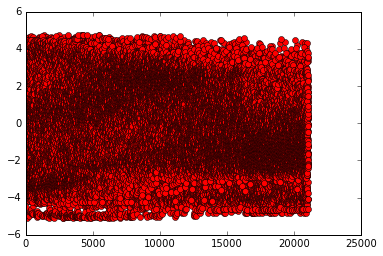

In [287]:
plt.plot(resist_matrix_2d, 'ro')
plt.show()

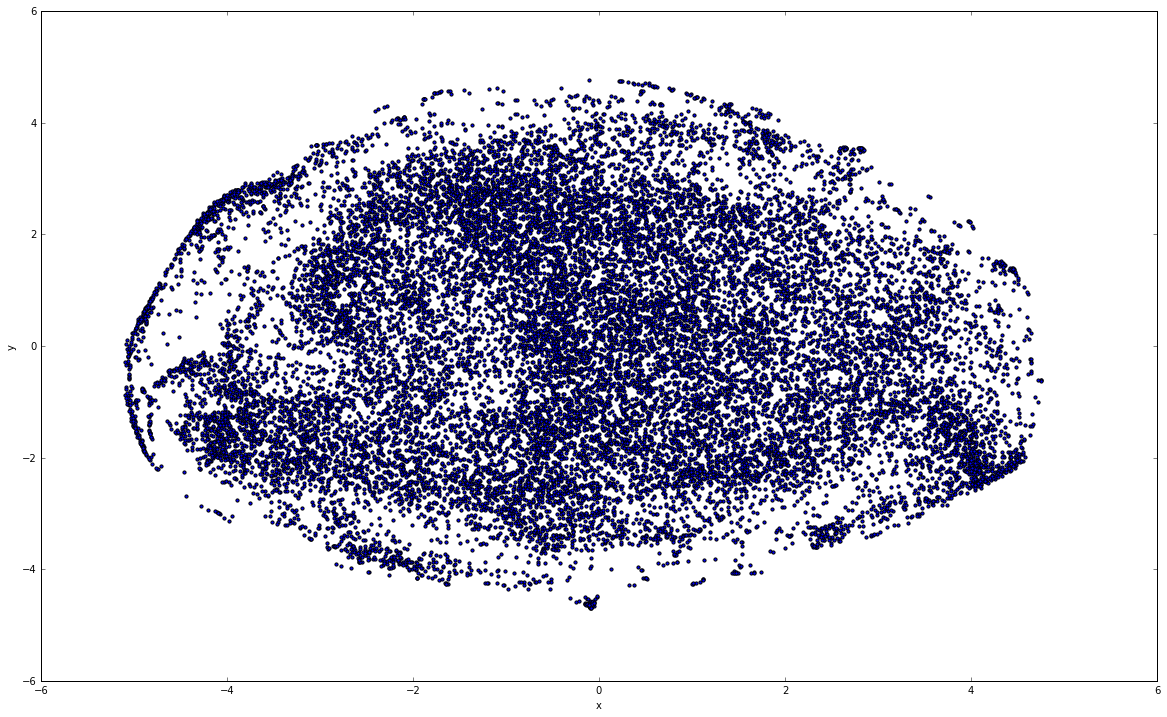

In [288]:
# Create points of visual
points = pd.DataFrame([(word, coords[0], coords[1])
        for word, coords in [(word, resist_matrix_2d[ali2vec.vocab[word].index])
            for word in ali2vec.vocab]],
    columns=["word", "x", "y"])

points.plot.scatter("x", "y", s=10, figsize=(20, 12))
plt.show()

In [289]:
# Function to zoom in
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

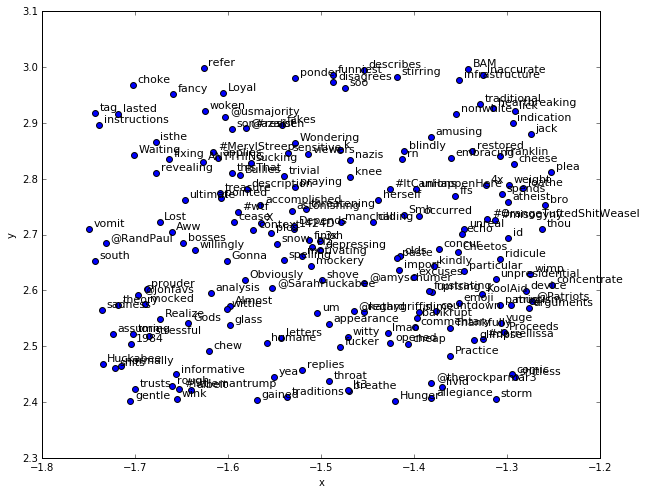

In [293]:
plot_region(x_bounds=(-1.75, -1.25), y_bounds=(2.4,3))
plt.show()

## Plots of first try 

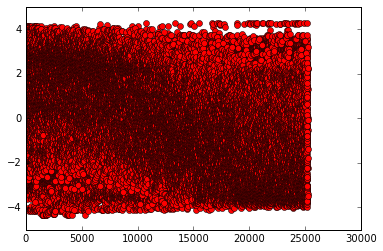

/Users/lorenadelaparralanda/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-03-01 11:10:41.582018. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [93]:
plt.show() # not sure what is going on here

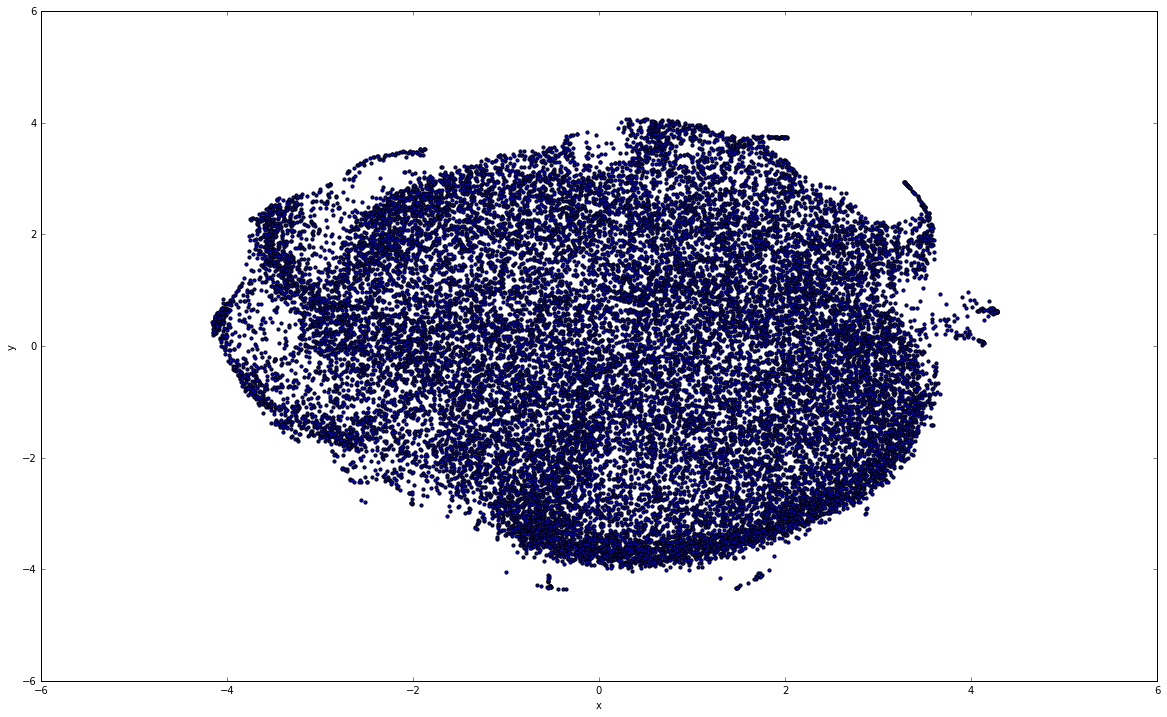

/Users/lorenadelaparralanda/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-03-01 11:16:13.640462. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [95]:
# 1st word2vec plot - repeat words because of punctuation
plt.show()

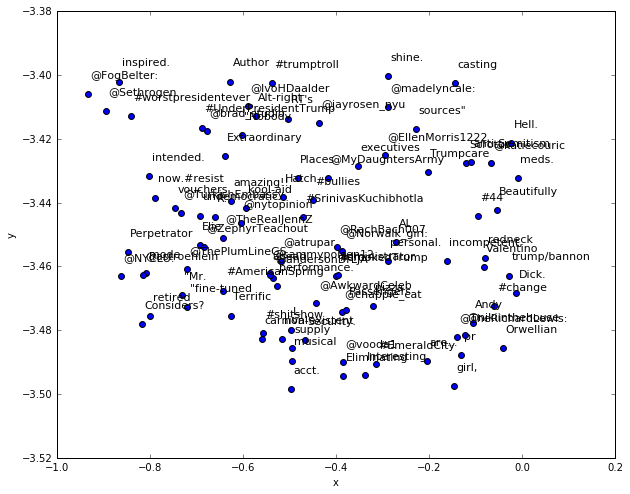

/Users/lorenadelaparralanda/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-03-01 12:16:04.081937. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [145]:
plt.figure(figsize=(10,10))
plot_region(x_bounds=(-1,0), y_bounds=(-3.5,-3.4))
plt.show()

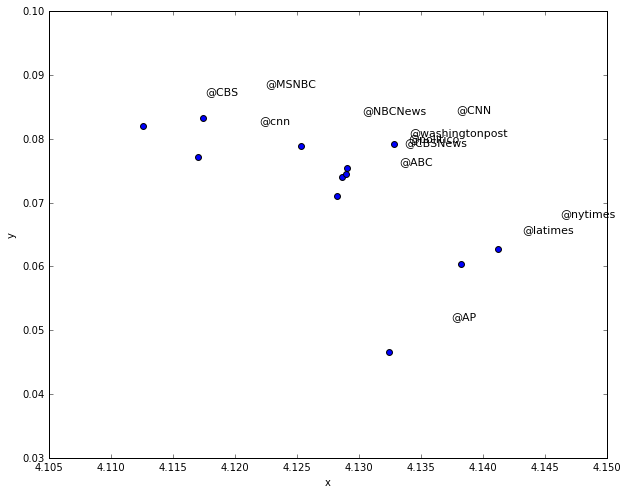

/Users/lorenadelaparralanda/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-03-01 11:32:24.756513. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [113]:
plt.show()